In [3]:
from urllib import request
import pandas as pd
import zipfile
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm_notebook
import tqdm

from torch.optim import SGD,Adam
from torch.nn import MSELoss
import torch.nn as nn
import matplotlib.pyplot as plt

In [4]:
DATASET_URL = 'http://files.grouplens.org/datasets/movielens/ml-100k.zip'
DATASET_ARCHIVE = 'ml-100k.zip'

request.urlretrieve(DATASET_URL, DATASET_ARCHIVE)
with zipfile.ZipFile(DATASET_ARCHIVE) as archive:
    archive.extractall()

### Task 1

1. Go over the NCF paper (https://arxiv.org/abs/1708.05031) to understand the architecture of the model
2. Implement NCF class. In particular:  
    a. implement __init__ to create the model achtecture  
    b. initialisation is already implemented for you  
    c. implement forward. Forward should take u_id and i_id and return the propability of consumption given u_id and i_id (what is the output layer?)
    d. Test your forward by providing some random u_id and i_id

In [5]:
class NeuMF(nn.Module):
    def __init__(self, nb_users, nb_items,
                 mf_dim, mlp_layer_sizes, dropout=0):
        
        if mlp_layer_sizes[0] % 2 != 0:
            raise RuntimeError('u dummy, mlp_layer_sizes[0] % 2 != 0')
        super(NeuMF, self).__init__()
        nb_mlp_layers = len(mlp_layer_sizes)
        #YOUR TASK: ADD EMBEEDING LAYERS TO THE MODEL - be careful with sizes ~5 lines of code
        self.mf_user_embed = nn.Embedding(nb_users, mf_dim)
        self.mf_item_embed = nn.Embedding(nb_items, mf_dim)
        self.mlp_user_embed = nn.Embedding(nb_users, mlp_layer_sizes[0] // 2)
        self.mlp_item_embed = nn.Embedding(nb_items, mlp_layer_sizes[0] // 2)
        self.dropout = dropout
        #YOUR TASK: ADD MLPs and the final layer ~4-6 lines of code
        self.mlp = nn.ModuleList()
        for i in range(1, nb_mlp_layers):
            self.mlp.extend([nn.Linear(mlp_layer_sizes[i - 1], mlp_layer_sizes[i])])  
        self.final = nn.Linear(mlp_layer_sizes[-1] + mf_dim, 1)
        #YOUR TASK: Initialze weights ~4 lines of code - use glorot
        self.mf_user_embed.weight.data.normal_(0., 0.01)
        self.mf_item_embed.weight.data.normal_(0., 0.01)
        self.mlp_user_embed.weight.data.normal_(0., 0.01)
        self.mlp_item_embed.weight.data.normal_(0., 0.01)
        def glorot_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features
            limit = np.sqrt(6. / (fan_in + fan_out))
            layer.weight.data.uniform_(-limit, limit)

        def lecunn_uniform(layer):
            fan_in, fan_out = layer.in_features, layer.out_features  # noqa: F841, E501
            limit = np.sqrt(3. / fan_in)
            layer.weight.data.uniform_(-limit, limit)
        for layer in self.mlp:
            if type(layer) != nn.Linear:
                continue
            glorot_uniform(layer)
        lecunn_uniform(self.final)

    def forward(self, user, item, sigmoid=False):
        #YOUR TASK: Implement model forward. ~15 lines of code
        xmfu = self.mf_user_embed(user)
        xmfi = self.mf_item_embed(item)
        xmf = xmfu * xmfi

        xmlpu = self.mlp_user_embed(user)
        xmlpi = self.mlp_item_embed(item)
        xmlp = torch.cat((xmlpu, xmlpi), dim=1)
        for i, layer in enumerate(self.mlp):
            xmlp = layer(xmlp)
            xmlp = nn.functional.relu(xmlp)
            if self.dropout != 0:
                xmlp = nn.functional.dropout(xmlp, p=self.dropout, training=self.training)

        x = torch.cat((xmf, xmlp), dim=1)
        x = self.final(x)
        if sigmoid:
            x = torch.sigmoid(x)
        return x

### Task 2

1. Implement ML100kDataset. In particular:  
    a. implement all needed functions that overload PyTorch Dataset
    b. Implement negaive sampling. This can be approximated negative sampling negative_samples=n means that if user A has m training points (positive) it will have n*m negive points

In [6]:
class ML100kDataset(Dataset):
    def __init__(self,file_name,negative_samples=1):
        ratings_df=pd.read_csv(file_name, header=None, names=['user_id', 'item_id', 'rating', 'timestamp'],delim_whitespace=True)
        max_item = np.max(ratings_df['item_id'])
        ratings_df.drop(['rating','timestamp'],axis=1,inplace=True)
        ratings = torch.from_numpy(ratings_df.values)         
        self.negative_samples = negative_samples
        self.raw_dataset_length = len(ratings_df.index) 
        self.length_after_augmentation = self.raw_dataset_length * (self.negative_samples + 1)
        #YOUR TASK: Implement negative sampling. ~7 lines of code. NOTE: the dataset does not have to be shuffled, but you can do this!
        #Sample neg users
        USER,ITEM=0,1
        neg_users = ratings[:,USER].repeat(self.negative_samples)
        self.users = torch.cat((ratings[:,USER], neg_users))
        #sample neg items
        neg_items = torch.empty_like(ratings[:,ITEM]).repeat(self.negative_samples).random_(0,max_item)
        self.items = torch.cat((ratings[:,ITEM], neg_items))
        #labels
        neg_label = torch.zeros_like(ratings[:,ITEM], dtype=torch.float32).repeat(self.negative_samples)
        self.labels = torch.cat((torch.ones_like(ratings[:,ITEM], dtype=torch.float32), neg_label))

    def __len__(self):
        return self.length_after_augmentation
  
    def __getitem__(self,idx):
        return self.users[idx],self.items[idx],self.labels[idx]

### Task 3

1. Implement training loop. In particular:  
    a. Every epoch you make log average train loss and test/eval loss  
    b. use different loss/optimiser/other HP. Use dependency injection to play with them.  
    c. Find "best" HP during cross-validation.  
    d. Check when model overfits with learning curves.  
    e. What are the conclusions.  
    f*. You can user HR@n from previous excersise to look for overfitting.  
    g*. Check the influence of shuffling on your results

In [18]:
import copy
from sklearn.model_selection import ParameterGrid, KFold
import torch.optim as optim


users_num = 943 + 1
movies_num = 1682 + 1

ds = ML100kDataset('ml-100k/u.data', 2)
kf = KFold(n_splits=5, shuffle=True)


param_grid = {
    'mf_dim': [8, 16],
    'mlp_layer_sizes': [[64, 32], [128, 64,32]],
    'dropout': [0.3, 0.6],
    'learning_rate': [0.001, 0.01]
}




best_loss = float('inf')
best_params = {}

for mf_dim in param_grid['mf_dim']:
    for mlp_layer_sizes in param_grid['mlp_layer_sizes']:
        for dropout in param_grid['dropout']:
            for learning_rate in param_grid['learning_rate']:
                print("Training with hyperparameters: mf_dim={}, mlp_layer_sizes={}, dropout={},learning_rate={}".format(mf_dim, mlp_layer_sizes, dropout,learning_rate))
                fold_losses = []
                for train_indices, test_indices in kf.split(ds):
                    train_ds = torch.utils.data.Subset(ds, train_indices)
                    test_ds = torch.utils.data.Subset(ds, test_indices)

                    train_dl = DataLoader(train_ds, batch_size=16 * 1024, shuffle=True)
                    test_dl = DataLoader(test_ds, batch_size=16 * 1024, shuffle=False)

                    model = NeuMF(users_num, movies_num, mf_dim, mlp_layer_sizes, dropout)
                    criterion = nn.BCELoss()
                    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

                    train_loss = []
                    test_loss = []
                    for epoch in range(3): # Used fewer epochs to minimize runtime
                        model.train()
                        tr_loss = []
                        print("Training " + str(epoch))
                        for (u, i, l) in tqdm.tqdm(train_dl):
                            optimizer.zero_grad()
                            yhat = model(u, i, sigmoid=True)
                            l = l.unsqueeze(1)
                            loss = criterion(yhat, l)
                            tr_loss.append(loss.detach().numpy())
                            loss.backward()
                            optimizer.step()
                        train_loss.append(np.mean(tr_loss))

                        model.eval()
                        predictions = []
                        with torch.no_grad():
                            t_loss = []
                            for i, (u, i, l) in enumerate(test_dl):
                                yhat = model(u, i, sigmoid=True)
                                predictions.append(yhat)
                                l = l.unsqueeze(1)
                                tl = criterion(yhat, l)
                                t_loss.append(tl)
                            test_loss = np.mean(t_loss)

                        fold_losses.append(test_loss)

                avg_loss = np.mean(fold_losses)
                print(f'Average Loss:{avg_loss}')

                if avg_loss < best_loss:
                    best_loss = avg_loss
                    best_params = {'mf_dim': mf_dim, 'mlp_layer_sizes': mlp_layer_sizes, 'dropout': dropout,'learning_rate':learning_rate}
                    

print("Best Loss:", best_loss) 
print("Best hyperparameters:", best_params)



Training with hyperparameters: mf_dim=8, mlp_layer_sizes=[64, 32], dropout=0.3,learning_rate=0.001
Training 0


100%|██████████| 15/15 [00:08<00:00,  1.79it/s]


Training 1


100%|██████████| 15/15 [00:07<00:00,  1.91it/s]


Training 2


100%|██████████| 15/15 [00:08<00:00,  1.84it/s]


Training 0


100%|██████████| 15/15 [00:09<00:00,  1.61it/s]


Training 1


100%|██████████| 15/15 [00:09<00:00,  1.61it/s]


Training 2


100%|██████████| 15/15 [00:08<00:00,  1.86it/s]


Training 0


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


Training 1


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Training 2


100%|██████████| 15/15 [00:08<00:00,  1.85it/s]


Training 0


100%|██████████| 15/15 [00:08<00:00,  1.86it/s]


Training 1


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


Training 2


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Training 0


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Training 1


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


Training 2


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


Average Loss:0.63394695520401
Training with hyperparameters: mf_dim=8, mlp_layer_sizes=[64, 32], dropout=0.3,learning_rate=0.01
Training 0


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Training 1


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


Training 2


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Training 0


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Training 1


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Training 0


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Training 1


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


Training 0


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Training 1


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Training 2


100%|██████████| 15/15 [00:12<00:00,  1.18it/s]


Training 0


100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Training 1


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


Training 2


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


Average Loss:0.47921091318130493
Training with hyperparameters: mf_dim=8, mlp_layer_sizes=[64, 32], dropout=0.6,learning_rate=0.001
Training 0


100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


Training 1


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Training 2


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Training 0


100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Training 1


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


Training 2


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


Training 0


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Training 1


100%|██████████| 15/15 [00:10<00:00,  1.47it/s]


Training 2


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


Training 0


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Training 1


100%|██████████| 15/15 [00:10<00:00,  1.46it/s]


Training 2


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


Training 0


100%|██████████| 15/15 [00:09<00:00,  1.53it/s]


Training 1


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


Training 2


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


Average Loss:0.63138747215271
Training with hyperparameters: mf_dim=8, mlp_layer_sizes=[64, 32], dropout=0.6,learning_rate=0.01
Training 0


100%|██████████| 15/15 [00:09<00:00,  1.50it/s]


Training 1


100%|██████████| 15/15 [00:09<00:00,  1.51it/s]


Training 2


100%|██████████| 15/15 [00:10<00:00,  1.50it/s]


Training 0


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Training 1


100%|██████████| 15/15 [00:10<00:00,  1.49it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Training 0


100%|██████████| 15/15 [00:09<00:00,  1.63it/s]


Training 1


100%|██████████| 15/15 [00:17<00:00,  1.16s/it]


Training 2


100%|██████████| 15/15 [00:13<00:00,  1.09it/s]


Training 0


100%|██████████| 15/15 [00:10<00:00,  1.48it/s]


Training 1


100%|██████████| 15/15 [00:10<00:00,  1.40it/s]


Training 2


100%|██████████| 15/15 [00:10<00:00,  1.45it/s]


Training 0


100%|██████████| 15/15 [00:09<00:00,  1.54it/s]


Training 1


100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Training 2


100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Average Loss:0.47861555218696594
Training with hyperparameters: mf_dim=8, mlp_layer_sizes=[128, 64, 32], dropout=0.3,learning_rate=0.001
Training 0


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Training 1


100%|██████████| 15/15 [00:14<00:00,  1.03it/s]


Training 2


100%|██████████| 15/15 [00:13<00:00,  1.10it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Training 1


100%|██████████| 15/15 [00:09<00:00,  1.60it/s]


Training 2


100%|██████████| 15/15 [00:09<00:00,  1.59it/s]


Training 0


100%|██████████| 15/15 [00:09<00:00,  1.66it/s]


Training 1


100%|██████████| 15/15 [00:10<00:00,  1.42it/s]


Training 2


100%|██████████| 15/15 [00:15<00:00,  1.06s/it]


Training 0


100%|██████████| 15/15 [00:16<00:00,  1.10s/it]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Training 2


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Training 0


100%|██████████| 15/15 [00:13<00:00,  1.14it/s]


Training 1


100%|██████████| 15/15 [00:17<00:00,  1.17s/it]


Training 2


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Average Loss:0.58832186460495
Training with hyperparameters: mf_dim=8, mlp_layer_sizes=[128, 64, 32], dropout=0.3,learning_rate=0.01
Training 0


100%|██████████| 15/15 [00:10<00:00,  1.43it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Training 2


100%|██████████| 15/15 [00:09<00:00,  1.58it/s]


Training 0


100%|██████████| 15/15 [00:10<00:00,  1.44it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Training 2


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


Training 2


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Average Loss:0.4781329333782196
Training with hyperparameters: mf_dim=8, mlp_layer_sizes=[128, 64, 32], dropout=0.6,learning_rate=0.001
Training 0


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Training 2


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


Training 0


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Training 2


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Average Loss:0.6043186783790588
Training with hyperparameters: mf_dim=8, mlp_layer_sizes=[128, 64, 32], dropout=0.6,learning_rate=0.01
Training 0


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


Training 2


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Training 0


100%|██████████| 15/15 [00:13<00:00,  1.15it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Average Loss:0.48148301243782043
Training with hyperparameters: mf_dim=16, mlp_layer_sizes=[64, 32], dropout=0.3,learning_rate=0.001
Training 0


100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Training 0


100%|██████████| 15/15 [00:10<00:00,  1.36it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Training 2


100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


Training 2


100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Average Loss:0.63184654712677
Training with hyperparameters: mf_dim=16, mlp_layer_sizes=[64, 32], dropout=0.3,learning_rate=0.01
Training 0


100%|██████████| 15/15 [00:10<00:00,  1.36it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


Training 0


100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


Training 2


100%|██████████| 15/15 [00:10<00:00,  1.38it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Training 2


100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Average Loss:0.4764985740184784
Training with hyperparameters: mf_dim=16, mlp_layer_sizes=[64, 32], dropout=0.6,learning_rate=0.001
Training 0


100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


Training 0


100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


Training 2


100%|██████████| 15/15 [00:10<00:00,  1.37it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


Average Loss:0.6511074900627136
Training with hyperparameters: mf_dim=16, mlp_layer_sizes=[64, 32], dropout=0.6,learning_rate=0.01
Training 0


100%|██████████| 15/15 [00:11<00:00,  1.29it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.35it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.32it/s]


Training 0


100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Training 2


100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.31it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.33it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.30it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.34it/s]


Average Loss:0.4754844605922699
Training with hyperparameters: mf_dim=16, mlp_layer_sizes=[128, 64, 32], dropout=0.3,learning_rate=0.001
Training 0


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Training 2


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Training 0


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.36it/s]


Average Loss:0.5893042683601379
Training with hyperparameters: mf_dim=16, mlp_layer_sizes=[128, 64, 32], dropout=0.3,learning_rate=0.01
Training 0


100%|██████████| 15/15 [00:10<00:00,  1.39it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Training 2


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Training 0


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Training 0


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.27it/s]


Average Loss:0.47696858644485474
Training with hyperparameters: mf_dim=16, mlp_layer_sizes=[128, 64, 32], dropout=0.6,learning_rate=0.001
Training 0


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Training 2


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Training 0


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Training 2


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Training 0


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Training 2


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.19it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Average Loss:0.6068328022956848
Training with hyperparameters: mf_dim=16, mlp_layer_sizes=[128, 64, 32], dropout=0.6,learning_rate=0.01
Training 0


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Training 2


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


Training 0


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Training 1


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


Training 2


100%|██████████| 15/15 [00:12<00:00,  1.25it/s]


Training 0


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.25it/s]


Training 0


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Training 2


100%|██████████| 15/15 [00:12<00:00,  1.23it/s]


Training 0


100%|██████████| 15/15 [00:12<00:00,  1.24it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.21it/s]


Training 2


100%|██████████| 15/15 [00:11<00:00,  1.26it/s]


Average Loss:0.47793275117874146
Best Loss: 0.47548446
Best hyperparameters: {'mf_dim': 16, 'mlp_layer_sizes': [64, 32], 'dropout': 0.6, 'learning_rate': 0.01}


Training 0


100%|██████████| 15/15 [00:12<00:00,  1.22it/s]


Training 1


100%|██████████| 15/15 [00:12<00:00,  1.20it/s]


Training 2


100%|██████████| 15/15 [00:12<00:00,  1.16it/s]


Training 3


100%|██████████| 15/15 [00:13<00:00,  1.12it/s]


Training 4


100%|██████████| 15/15 [00:19<00:00,  1.32s/it]


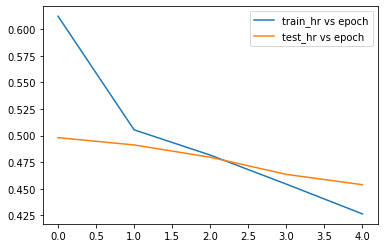

In [23]:

import copy
# Define the HIT RATIO function
def HR_at_n(R, R_hat, R_exclude, n=10):
    
    R_hat=copy.copy(R_hat)
    exclude_items_per_user=np.sum(R_exclude>0,axis=1)
    R_hat[R_exclude>0]= -np.inf
    pred_items=np.argsort(-R_hat,axis=1)
    true_items=np.argsort(-R,axis=1)
    exclude_items_cnt=np.sum(R_exclude>0,axis=1)
    test_items_cnt=np.sum(R>0,axis=1)
    hr_total=0
    for user_id in range(pred_items.shape[0]):
        min_end=min(n,pred_items.shape[1]-exclude_items_cnt[user_id])
        pred_items_for_user=pred_items[user_id,:min_end]
        propper_itemcnt_for_user=np.sum(np.in1d(pred_items_for_user,true_items[user_id,:test_items_cnt[user_id]]))
        if test_items_cnt[user_id]>0:
            hr_for_user=propper_itemcnt_for_user/min(n,test_items_cnt[user_id])
            hr_total+=hr_for_user
    hr_total /=np.shape(R)[0]
    
    return hr_total

users_num = 943 + 1
movies_num = 1682 + 1
mf_dim = 16
mlp_layer_sizes = [64, 32]
dropout = 0.6
learning_rate = 0.01

ds_train = ML100kDataset('ml-100k/u1.base', 2)
ds_test = ML100kDataset('ml-100k/u1.test', 2)
train_dl = DataLoader(ds_train, batch_size=16 * 1024, shuffle=True)
test_dl = DataLoader(ds_test, batch_size=16 * 1024, shuffle=False)
model = NeuMF(users_num, movies_num, mf_dim, mlp_layer_sizes, dropout)

criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)
test_hr = []
train_hr = []
test_loss = []
train_loss = []

for epoch in range(5):
    model.train()
    tr_loss=[]
    tr_hr = []
    print("Training " + str(epoch))
    for (u, i, l) in tqdm.tqdm(train_dl):
        optimizer.zero_grad()
        yhat = model(u, i, sigmoid=True)
        l = l.unsqueeze(1)
        loss = criterion(yhat, l)
        tr_loss.append(loss.detach().numpy())
        loss.backward()
        optimizer.step()
        
        tr_hr.append(HR_at_n(l.detach().numpy(), yhat.detach().numpy(), np.zeros_like(l.detach().numpy())))
       

    train_loss.append(np.mean(tr_loss))    
    train_hr.append(np.mean(tr_hr))
    
    model.eval()
    test_hr_epoch = []
    with torch.no_grad():
        t_loss=[]
        for i, (u, i, l) in enumerate(test_dl):
            yhat = model(u, i, sigmoid=True)
            l = l.unsqueeze(1)
            tl = criterion(yhat, l)
            t_loss.append(tl)
            test_hr_epoch.append(HR_at_n(l.detach().numpy(), yhat.detach().numpy(), np.zeros_like(l.detach().numpy())))
        test_loss.append(np.mean(t_loss))
        test_hr.append(np.mean(test_hr_epoch))


plt.plot(train_loss, label='train_hr vs epoch')
plt.plot(test_loss, label='test_hr vs epoch')
plt.legend()
plt.show()

In [20]:
print(f'HR@10 for train set {train_hr[-1]}')
print(f'HR@10 for test set {test_hr[-1]}')

HR@10 for train set 0.3331936143009538
HR@10 for test set 0.30517578125
